## Packets

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import lime
import shap
import lime.lime_tabular

## Model Selection

In [2]:
def get_scores(y_test, y_pred, acc):
    labels = ["U", "P"]

    acc = round(acc, 2)

    print(classification_report(y_test, y_pred))

    #Confusion Matrix
    norms = [None, "true"]
    for norm in norms:
        cm = confusion_matrix(y_test, y_pred, normalize=norm)

        plt.figure(figsize=(7,7))
        
        if norm == "true":
            sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuPu', xticklabels = labels, yticklabels = labels)
        else:
            sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'BuPu', xticklabels = labels, yticklabels = labels)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        all_sample_title = 'Accuracy Score: {0}'.format(acc)
        plt.title(all_sample_title, size = 15)


def svm(X_train, X_test, y_train, y_test):
    clf = SVC(kernel = "rbf", decision_function_shape = "ovo", probability=True)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = clf.score(X_test, y_test)

    get_scores(y_test, y_pred, acc)
    return clf

def random_forest(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    acc = rf.score(X_test, y_test)

    get_scores(y_test, y_pred, acc)
    return rf

def mlp(X_train, X_test, y_train, y_test, iters=300):
    clf = MLPClassifier(random_state=42, max_iter=iters)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = clf.score(X_test, y_test)

    get_scores(y_test, y_pred, acc)
    return clf, y_pred

## Explainability

In [13]:
def lime_explanation(model, X_test, X_train, y_train, features_names, i=0):
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train,
                                                    mode='classification',
                                                    training_labels=y_train,
                                                    feature_names=features_names,
                                                    verbose=True)

    exp = explainer.explain_instance(X_test[i], model.predict_proba, num_features=len(features_names), top_labels=1)
    exp.show_in_notebook()

def shap_explanation(model, X_test, features_names, sample_indx = 0):
    # ['degree', 'ring', 'NetRank', 'NetShort', 'HeatDiff', 'InfoDiff']
    # 100 samples from training set
    x100 = shap.utils.sample(X_test, 100)

    # for fn in features_names:
    #     shap.plots.partial_dependence(
    #         fn, model, x100, ice=False,
    #         model_expected_value=True, feature_expected_value=True,
    #         feature_names=features_names
    #     )
    
    # Compute the shap values
    explainer = shap.Explainer(model, x100, feature_names=features_names)
    shap_values = explainer(X_test)

    for fn in features_names:
        shap.partial_dependence_plot(
            fn, model, x100, model_expected_value=True,
            feature_expected_value=True, ice=False,
            shap_values=shap_values[sample_indx:sample_indx+1,:],
            feature_names=features_names
        )
    
    shap.plots.waterfall(shap_values[sample_indx], max_display=14)
    print("--- Beeswarm ---")
    shap.plots.beeswarm(shap_values, max_display=14)

    shap.initjs()
    shap.plots.force(shap_values[sample_indx])

    shap.initjs()
    shap.plots.force(shap_values[:1000])

    shap.plots.scatter(shap_values, ylabel="SHAP\n")

## NeDBIT Features

### Data

In [3]:
nedbit_features = pd.read_csv('Datasets/C0006142_Malignant_neoplasm_of_breast_features.csv')
nedbit_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19761 entries, 0 to 19760
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      19761 non-null  object 
 1   class     19761 non-null  int64  
 2   degree    19761 non-null  int64  
 3   ring      19761 non-null  int64  
 4   NetRank   19761 non-null  float64
 5   NetShort  19761 non-null  float64
 6   HeatDiff  19761 non-null  float64
 7   InfoDiff  19761 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 1.2+ MB


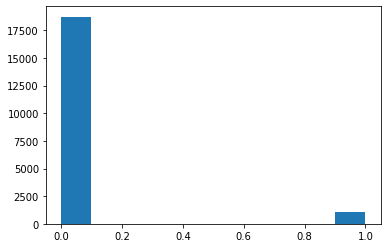

In [4]:
geneNames = nedbit_features.pop("name").values

yData = nedbit_features.pop("class").values
plt.hist(yData)
plt.show()

In [5]:
nedbit_features.pop('degree')
nedbit_features.pop('ring')

0        1
1        2
2        2
3        2
4        2
        ..
19756    3
19757    3
19758    4
19759    4
19760    3
Name: ring, Length: 19761, dtype: int64

In [6]:
features_names = nedbit_features.columns.to_list()
features_names

['NetRank', 'NetShort', 'HeatDiff', 'InfoDiff']

In [7]:
xData = nedbit_features.values
xData[0]

array([3.776224e-01, 6.621135e+03, 7.857457e-01, 8.043124e-01])

In [8]:
num_features = xData.shape[1]
num_features

4

In [9]:
transformer = RobustScaler().fit(xData)
xData = transformer.transform(xData)

In [10]:
np.random.seed(42)
train_ratio = 0.70
X_train, X_test, y_train, y_test = train_test_split(xData, yData, test_size= 1 - train_ratio, random_state = 42, shuffle = True, stratify = yData)

### SVM

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5621
           1       1.00      1.00      1.00       308

    accuracy                           1.00      5929
   macro avg       1.00      1.00      1.00      5929
weighted avg       1.00      1.00      1.00      5929



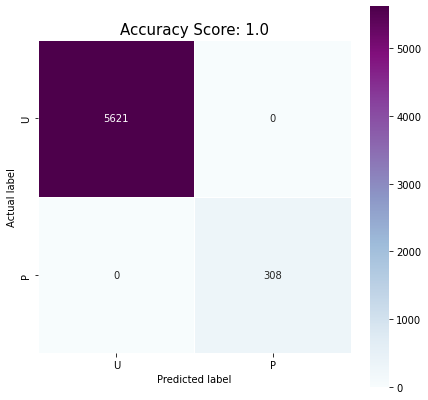

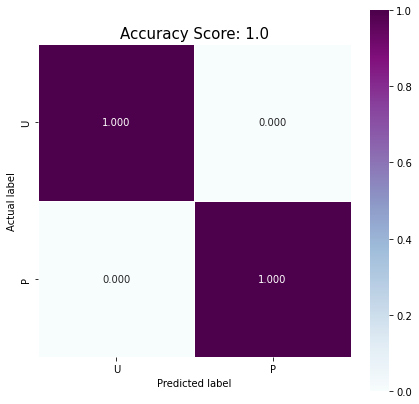

In [11]:
svm_model = svm(X_train, X_test, y_train, y_test)

In [14]:
lime_explanation(svm_model, X_train, X_test, y_train, features_names, 5)

Intercept -0.007990630843852313
Prediction_local [0.16978324]
Right: 0.9999896282757529


Exact explainer: 5930it [00:28, 139.51it/s]                          


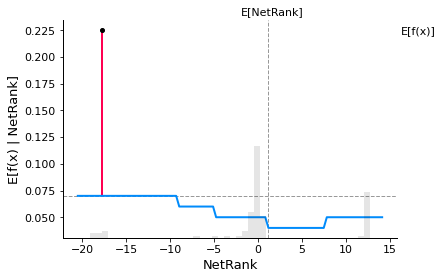

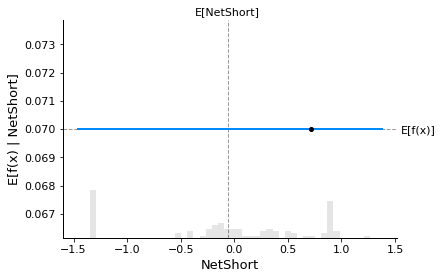

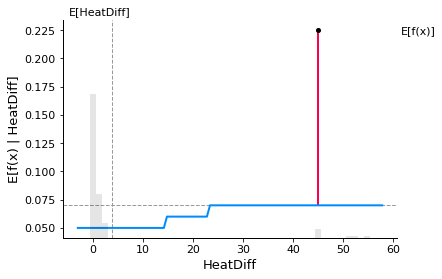

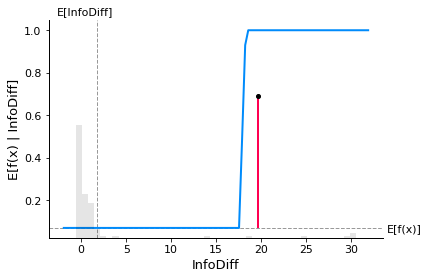

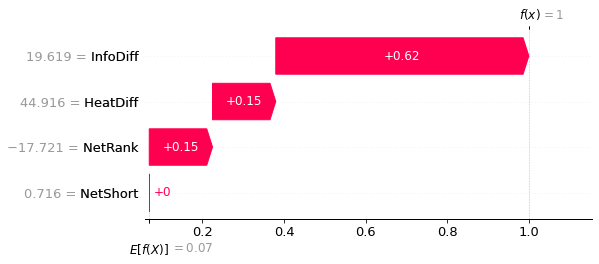

--- Beeswarm ---


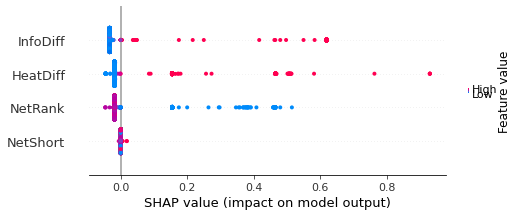

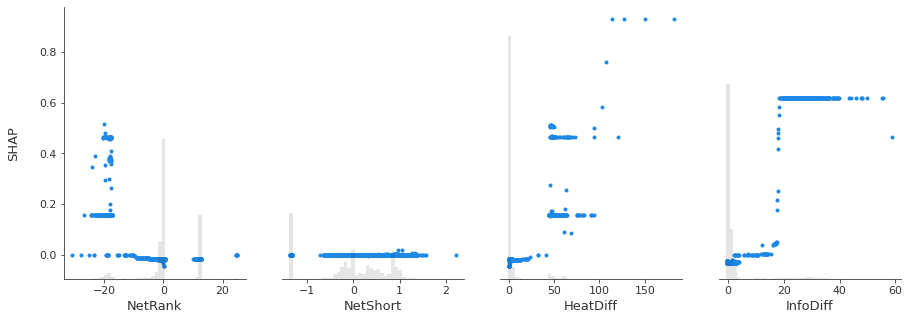

In [15]:
shap_explanation(svm_model.predict, X_test, features_names, sample_indx=5)

### Random Forest

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5621
           1       1.00      1.00      1.00       308

    accuracy                           1.00      5929
   macro avg       1.00      1.00      1.00      5929
weighted avg       1.00      1.00      1.00      5929



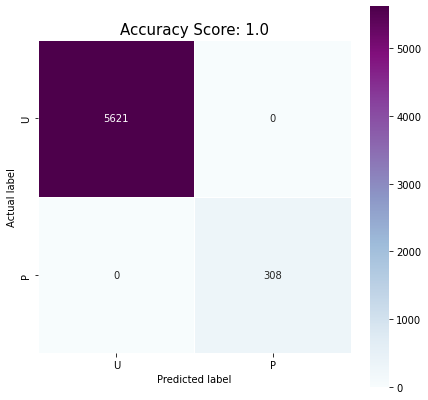

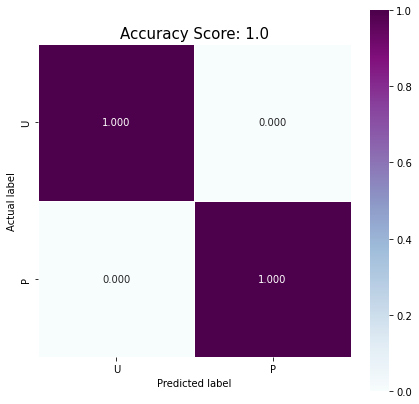

In [32]:
rf_model = random_forest(X_train, X_test, y_train, y_test)

In [64]:
lime_explanation(rf_model, X_train, X_test, y_train, features_names, 5)

Intercept -0.005387974943319669
Prediction_local [0.16250463]
Right: 1.0


Exact explainer: 5930it [01:39, 53.61it/s]                          


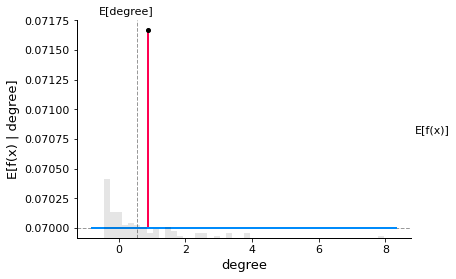

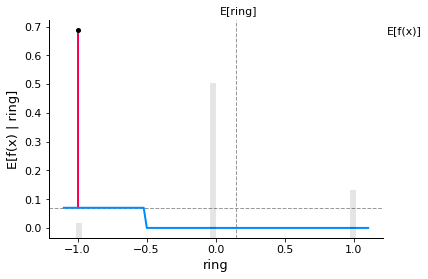

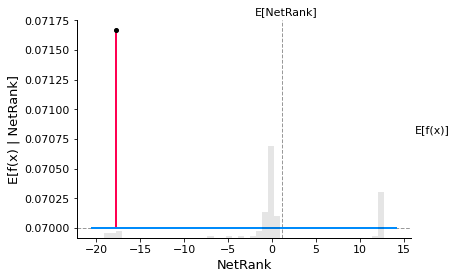

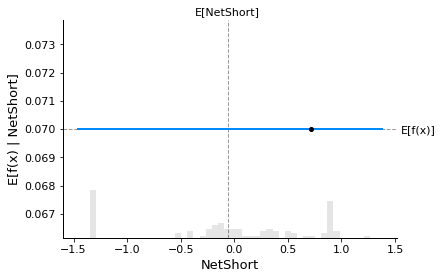

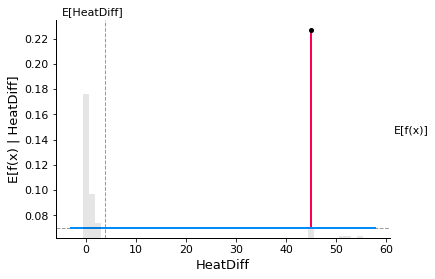

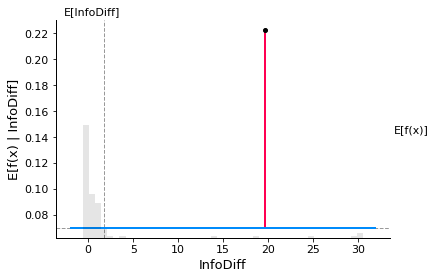

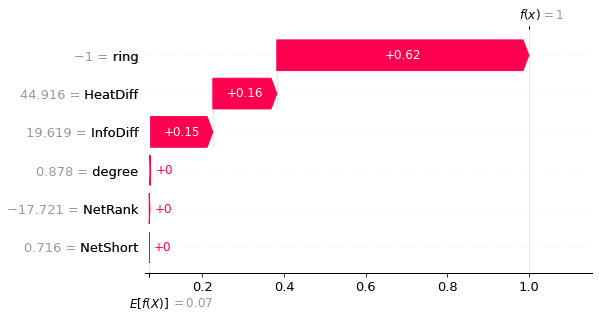

--- Beeswarm ---


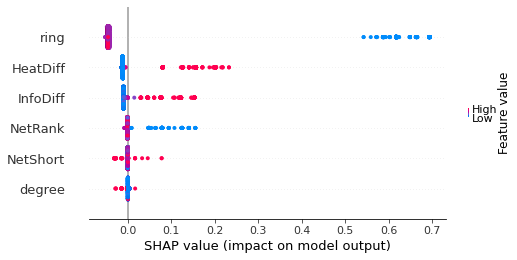

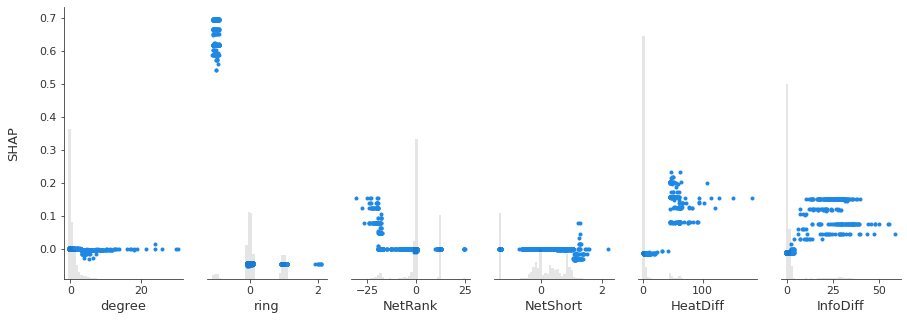

In [42]:
shap_explanation(rf_model.predict, X_test, features_names, sample_indx=5)

### MLP

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5621
           1       1.00      1.00      1.00       308

    accuracy                           1.00      5929
   macro avg       1.00      1.00      1.00      5929
weighted avg       1.00      1.00      1.00      5929



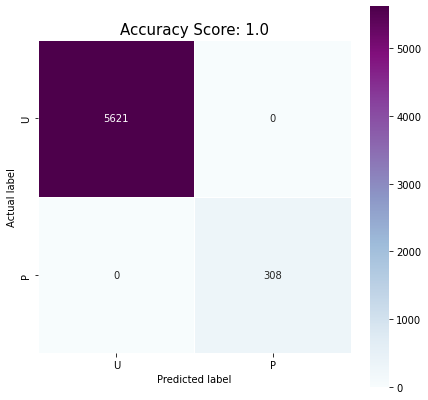

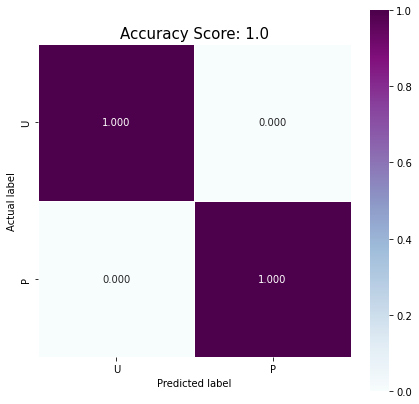

In [16]:
mlp_model, y_pred = mlp(X_train, X_test, y_train, y_test)

In [5]:
idx = 0

for i in range(len(yData)):
    if yData[i] == 1:
        idx = i
        break

idx

0

In [17]:
lime_explanation(mlp_model, X_train, X_test, y_train, features_names, 5)

Intercept -0.026136103529340662
Prediction_local [0.16937753]
Right: 0.9998874394051103


Exact explainer: 5930it [00:52, 90.72it/s]                           


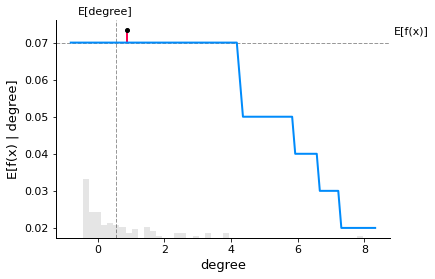

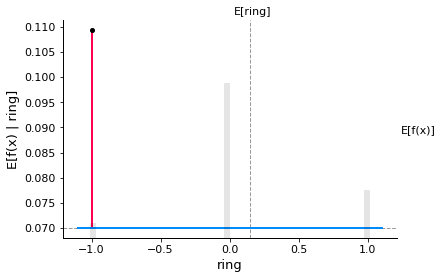

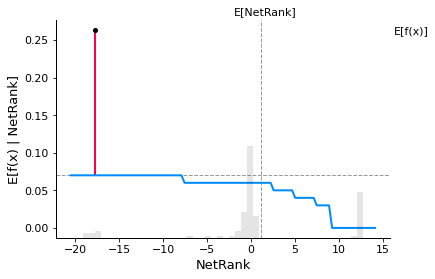

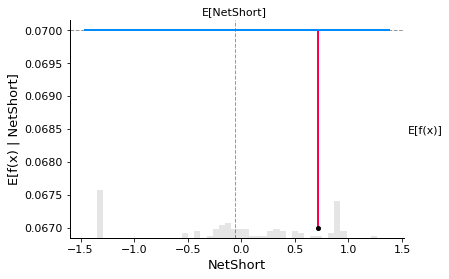

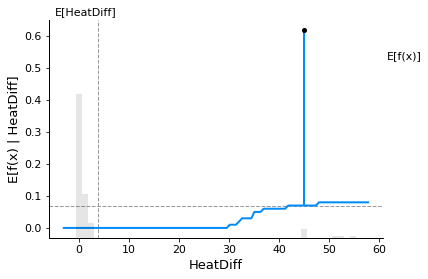

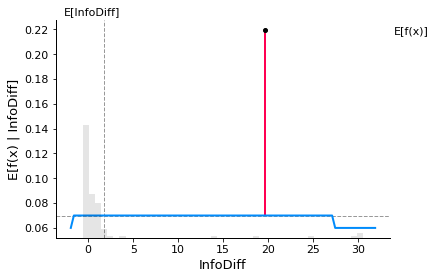

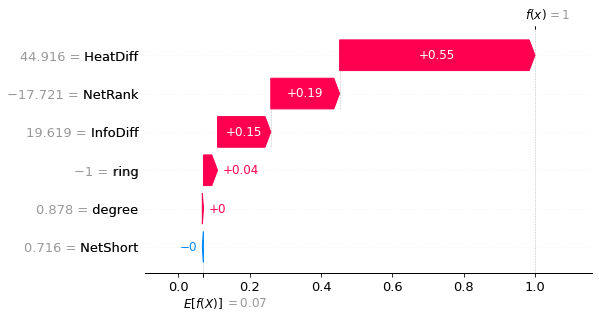

--- Beeswarm ---


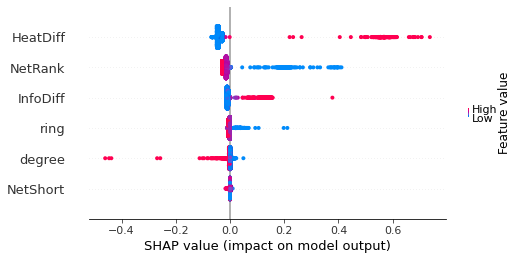

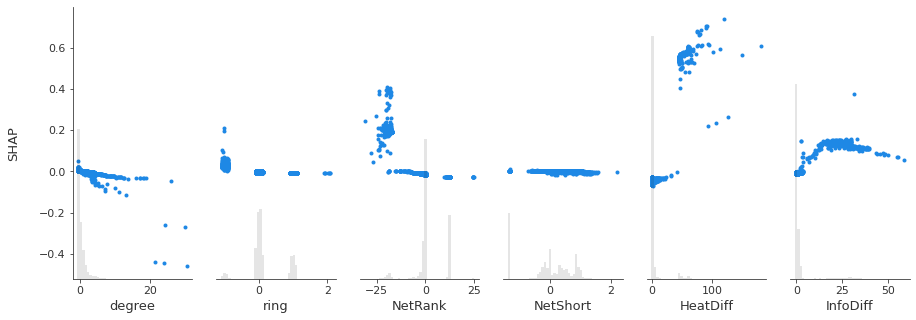

In [45]:
shap_explanation(mlp_model.predict, X_test, features_names, sample_indx=5)

## Centrality Measures

### Data

In [41]:
G = nx.read_gml('Graphs/graph_with_normalized_centrality.gml')

d = {}

associated_genes = pd.read_csv('Datasets/C0006142_Malignant_neoplasm_of_breast_features.csv').set_index('name').T.to_dict()

for node in G:
    if node not in d:
        d[node] = {}
        d[node]['degree']       = G.nodes[node]['degree']
        d[node]['betweenness']  = G.nodes[node]['betweenness']
        d[node]['eigenvector']  = G.nodes[node]['eigenvector']
        d[node]['closeness']    = G.nodes[node]['closeness']
        d[node]['associated']   = associated_genes[node]['class']
        

centrality_pd = pd.DataFrame.from_dict(d, orient='index')
centrality_pd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19761 entries, MAP2K4 to ST13P5
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   degree       19761 non-null  float64
 1   betweenness  19761 non-null  float64
 2   eigenvector  19761 non-null  float64
 3   closeness    19761 non-null  float64
 4   associated   19761 non-null  float64
dtypes: float64(5)
memory usage: 926.3+ KB


In [42]:
features_names = centrality_pd.columns.to_list()
features_names

['degree', 'betweenness', 'eigenvector', 'closeness', 'associated']

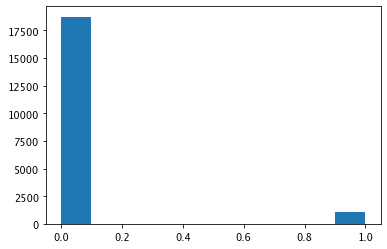

In [43]:
yData = centrality_pd.pop("associated").values
plt.hist(yData)
plt.show()

In [44]:
np.random.seed(42)

train_ratio = 0.70
xData = nedbit_features.values
X_train, X_test, y_train, y_test = train_test_split(xData, yData, test_size= 1 - train_ratio, random_state = 42, shuffle = True, stratify = yData)

### SVM

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      5621
         1.0       0.00      0.00      0.00       308

    accuracy                           0.95      5929
   macro avg       0.47      0.50      0.49      5929
weighted avg       0.90      0.95      0.92      5929



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


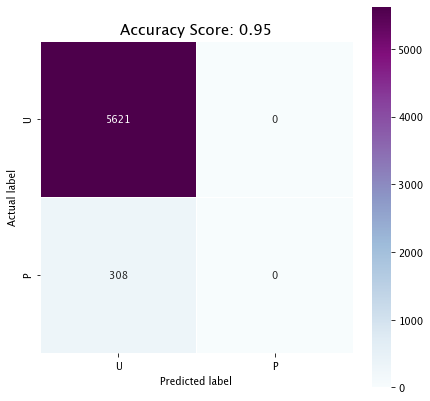

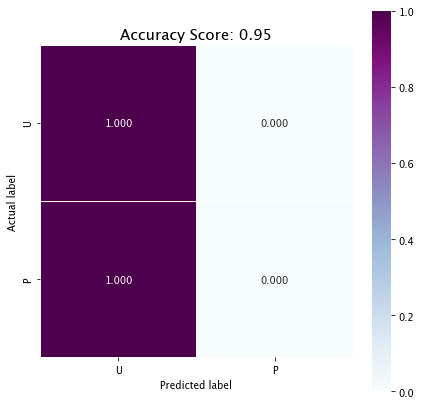

In [45]:
svm_model = svm(X_train, X_test, y_train, y_test)

In [22]:
lime_explanation(svm_model, X_train, X_test, y_train, features_names, 10)

IndexError: list index out of range

### Random Forest

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      5621
         1.0       0.00      0.00      0.00       308

    accuracy                           0.95      5929
   macro avg       0.47      0.50      0.49      5929
weighted avg       0.90      0.95      0.92      5929



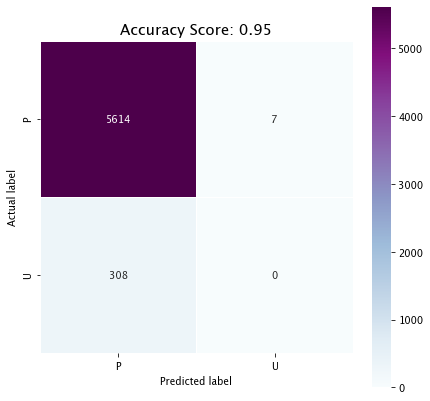

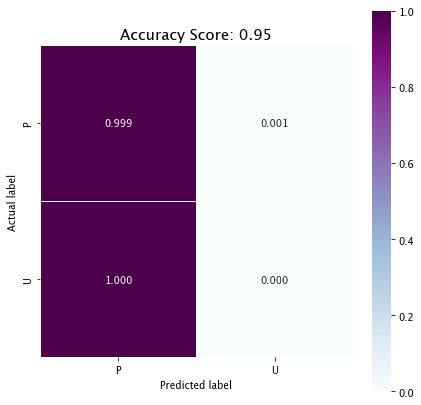

In [46]:
random_forest(X_train, X_test, y_train, y_test)

### MLP

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      5621
         1.0       0.00      0.00      0.00       308

    accuracy                           0.95      5929
   macro avg       0.47      0.50      0.49      5929
weighted avg       0.90      0.95      0.92      5929



/Users/gianlucadecarlo/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gianlucadecarlo/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gianlucadecarlo/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

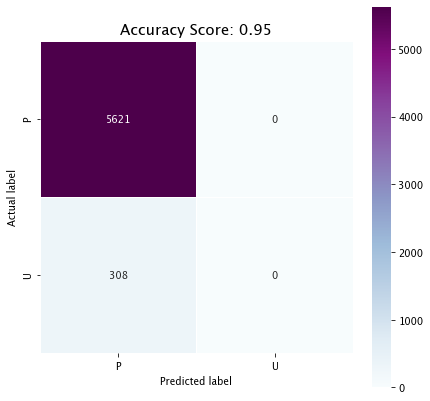

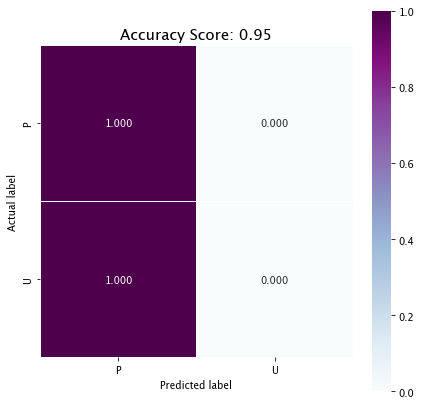

In [78]:
mlp(X_train, X_test, y_train, y_test)